In [132]:
#imports!
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, classification_report
from joblib import dump, load
%load_ext autoreload
%autoreload 2
print("we workin'!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
we workin'!


In [133]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    """Varimax is for Rotated Principal Component Analysis. Given a matrix (of loadings) Phi, 
    find an expression of the subspace spanned by Phi that maximizes the variance of the squared loadings.
    Basically rotate Phi so that there are a lot of zero weights and it's easier to understand.
    """
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: 
            print(i) 
            break
    return dot(Phi, R), R

def show_matrix(mat, ax=None, **kwargs):
    """Convenience function for plotting a matrix"""
    if not 'cmap' in kwargs.keys():
        kwargs['cmap']= plt.cm.bwr
    if not ax:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = ax.figure
    ax.matshow(mat.T, **kwargs)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            c = mat[i,j]
            ax.text(i, j, f'{c:0.2f}', va='center', ha='center')
    return fig, ax
    
    
def show_loadings(loadings, yticks=None, ax=None, **kwargs):
    """Convenience function for plotting a loading, just matrix with labeled ticks"""
    fig, ax = show_matrix(loadings, ax=ax,**kwargs)
    ax.set_xticks(range(loadings.shape[0]))
    ax.set_xticklabels([f'PC{i+1}' for i in range(loadings.shape[0])])
    if yticks:
        ax.set_yticks(range(len(yticks)))
        ax.set_yticklabels(yticks)
    return ax
print('functions are a go!')

functions are a go!


# Part 1: Data preprocessing: Train/Val split, normalization, PCA and rotation

In [134]:
# initial loading of all train/validation data. Not loading any test data as this notebook is for model development and tuning.
all_sep_df = pd.DataFrame()
for year in ['2014', '2015']:#, '2016']:
    savefile = f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_{year}_4.pickle'
    temp_df = pickle.load(open(savefile, 'rb'))
    all_sep_df = pd.concat([all_sep_df, temp_df], ignore_index=True)
    
    
labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}
ordering = [4, 0, 2, 3, 1, 5]
short_labels = {0: 'Closed MCC ', 1: 'Clust. Cu', 2: 'Disorg. MCC',
        3: 'Open MCC', 4: 'Solid St', 5: 'Supp. Cu'}


vars_to_use_noanom = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
var_labels_noanom = ['Sfc. div.', '700mb div', 'SST', 'EIS', 'LTS', '700mb RH', '10m wspd.' ,'Sfc. pres.', 'Col. Q$_V$', '2m T', 'MCAO idx', 'T$_{adv}$', '700mb T']
train_subset = all_sep_df[vars_to_use_noanom + ['low_cf', 'cat', 'lat', 'lon']].copy()  # including two different y variables.
vars_to_use = [j for i in vars_to_use_noanom for j in [i, i+'_anom', i+'_climanom']]
var_labels = [j for i in var_labels_noanom for j in [i, i+'_anom', i+'_climanom']]
all_bads = np.zeros_like(train_subset['low_cf'])
for varname in vars_to_use_noanom:
    train_subset[varname+'_anom'] = all_sep_df[varname] - all_sep_df[varname+'_region']
    train_subset[varname+'_climanom'] = all_sep_df[varname] - all_sep_df[varname+'_climo']


all_bads = np.zeros_like(train_subset['low_cf'])
for varname in vars_to_use:
    low_thresh = np.nanmedian(train_subset[varname]) - (np.nanmedian(train_subset[varname])-np.nanpercentile(train_subset[varname], 0.5))*2
    high_thresh = np.nanmedian(train_subset[varname]) + (np.nanpercentile(train_subset[varname], 99.5)-np.nanmedian(train_subset[varname]))*2
    bads = np.logical_or(train_subset[varname]<low_thresh, train_subset[varname]>high_thresh)
    train_subset[varname][bads] = np.nan
    all_bads = np.logical_or(all_bads, bads)
#     print(f'{varname}: {np.sum(bads)/len(bads):%} bad')

print(f'training set rejects: {np.sum(all_bads)/len(all_bads):%} bad')

# MERRA2_T_adv (*86400) should be ~-5 to 5 K/day or so, removing rows with abs(T_adv)>5 k/day.
# train_subset.loc[np.abs(train_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
train_subset = train_subset.dropna(axis='index')  # removing any row with with a missing value

#If  only making a model to fit e.g. Clustered and Suppressed categories, set subset_categories to [1, 5]
subset_categories = False#[0,2,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}

    
test_df = pickle.load(open(f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/classified_df_final.SEP_2016_4.pickle', 'rb'))
test_subset = test_df[vars_to_use_noanom + ['low_cf', 'cat', 'lat', 'lon']].copy()
all_bads = np.zeros_like(test_subset['low_cf'])
for varname in vars_to_use_noanom:
    test_subset[varname+'_anom'] = test_df[varname] - test_df[varname+'_region']
    test_subset[varname+'_climanom'] = test_df[varname] - test_df[varname+'_climo']


all_bads = np.zeros_like(test_subset['low_cf'])
for varname in vars_to_use:
    low_thresh = np.nanmedian(test_subset[varname]) - (np.nanmedian(test_subset[varname])-np.nanpercentile(test_subset[varname], 0.5))*2
    high_thresh = np.nanmedian(test_subset[varname]) + (np.nanpercentile(test_subset[varname], 99.5)-np.nanmedian(test_subset[varname]))*2
    bads = np.logical_or(test_subset[varname]<low_thresh, test_subset[varname]>high_thresh)
    test_subset[varname][bads] = np.nan
    all_bads = np.logical_or(all_bads, bads)
#     print(f'{varname}: {np.sum(bads)/len(bads):%} bad')

print(f'test set rejects: {np.sum(all_bads)/len(all_bads):%} bad')    
    
    
# print(f'all: {np.sum(all_bads)/len(all_bads):%} bad')


# test_subset.loc[np.abs(test_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
test_subset = test_subset.dropna(axis='index')  # removing any row with with a missing value


training set rejects: 0.646340% bad
test set rejects: 0.596801% bad


In [135]:
# Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[vars_to_use].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
train_features, val_features, train_labels, val_labels, train_cats, val_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 45, stratify=strat_data)

In [136]:
# Scale the data using the StandardScaler class. Note that we fit the scaler only on the train features.
# This scaling is part of the model, and this same scaling must be applied to all test data 
# without any more refitting.
x_scaler = StandardScaler().fit(train_features)
x_train = x_scaler.transform(train_features)
x_val = x_scaler.transform(val_features)
x_all = x_scaler.transform(x_data)

test_data = test_subset[vars_to_use].values.copy()
x_test = x_scaler.transform(test_data)
test_cats = test_subset['cat'].values.copy()
test_labels = test_subset['low_cf'].values.copy()

In [137]:
x_train.shape

(235699, 39)

In [138]:
# bin by hexile of train_cf, can safely be ignored usually
pctiles = [np.percentile(train_labels,i) for i in np.arange(0,100,100/6)][::-1]
train_cats_cf = 5-np.argmax(np.subtract(train_labels[:,None], pctiles)>0, axis=1)
val_cats_cf = 5-np.argmax(np.subtract(val_labels[:,None], pctiles)>0, axis=1)
test_cats_cf = 5-np.argmax(np.subtract(test_labels[:,None], pctiles)>0, axis=1)

In [139]:
# Performing Principal Component Analysis on the training data, to reduce correlations. 
# The numpy pca functions we insufficiently flexible so they are rewritten here
# after this, rot_norm_pcs is our new x_train, and rot_norm_pcs_test is our new x_test.
n, p = x_train.shape
k = 22   # this is the # of PC's to keep if doing truncated PCA
U, S_a_all, Vt= np.linalg.svd(x_train, full_matrices=False)
#let's flip some signs
for i,v in enumerate(Vt):
    if np.sign(v[np.argmax(np.abs(v))])==-1:
        Vt[i] = -Vt[i]
        U[:,i] = -U[:,i]
if k<p:
    U=U[:,:k]
    S_a = S_a_all[:k]
    Vt = Vt[:k,:]
else: 
    S_a = S_a_all
pct_var = S_a_all**2/np.sum(S_a_all**2)
cum_var = np.cumsum(pct_var)

V = Vt.T
S = np.diag(S_a)
recon_x = np.dot(np.dot(U, S), Vt)
norm_pcs = np.sqrt(n-1)*U
loadings = np.dot(V,S)/np.sqrt(n-1)
rot_loadings, R = varimax(loadings)
rot_norm_pcs = np.dot(norm_pcs, R) # x_train~ = np.dot(rot_norm_pcs, rot_loadings.T)
pct_var_rot = np.sum(rot_loadings**2, axis=0)/np.sum(rot_loadings**2)

rot_norm_pcs_val = np.matmul(x_val, np.linalg.pinv(rot_loadings.T))
rot_norm_pcs_all = np.matmul(x_all, np.linalg.pinv(rot_loadings.T))

rot_norm_pcs_test = np.matmul(x_test, np.linalg.pinv(rot_loadings.T))

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [140]:
X_ish = x_scaler.inverse_transform(np.matmul(rot_norm_pcs_all, rot_loadings.T))

In [141]:
x_data.shape

(314266, 39)

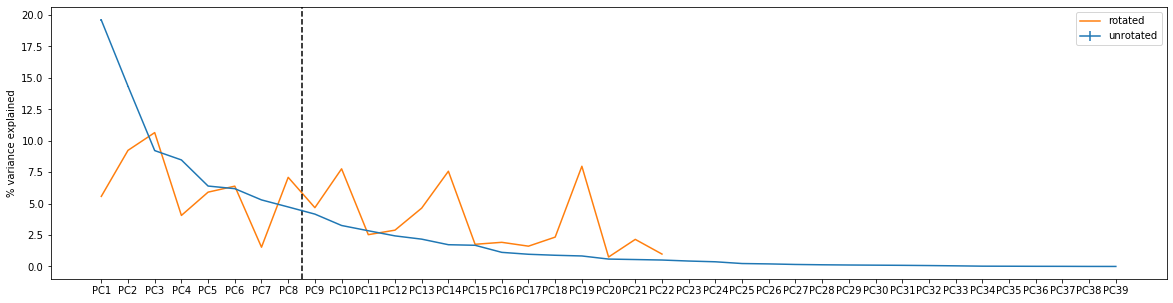

In [142]:
# Plotting the variance explained by the PCs, as well as the rotated PCs
pct_var_errbars = pct_var*100 * np.sqrt(2/n)

fig, ax = plt.subplots(figsize=(20,5))
ax.errorbar(x=range(p), y=pct_var*100, yerr=pct_var_errbars, label='unrotated')
ax.plot(pct_var_rot*100, label='rotated')
ax.set_xticks(range(p))
ax.set_xticklabels([f'PC{i+1}' for i in range(p)])
ax.axvline(7.5, c='k', ls='--')
ax.legend()
ax.set_ylabel("% variance explained");
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/ch3_percent_variance.png', bbox_inches='tight')

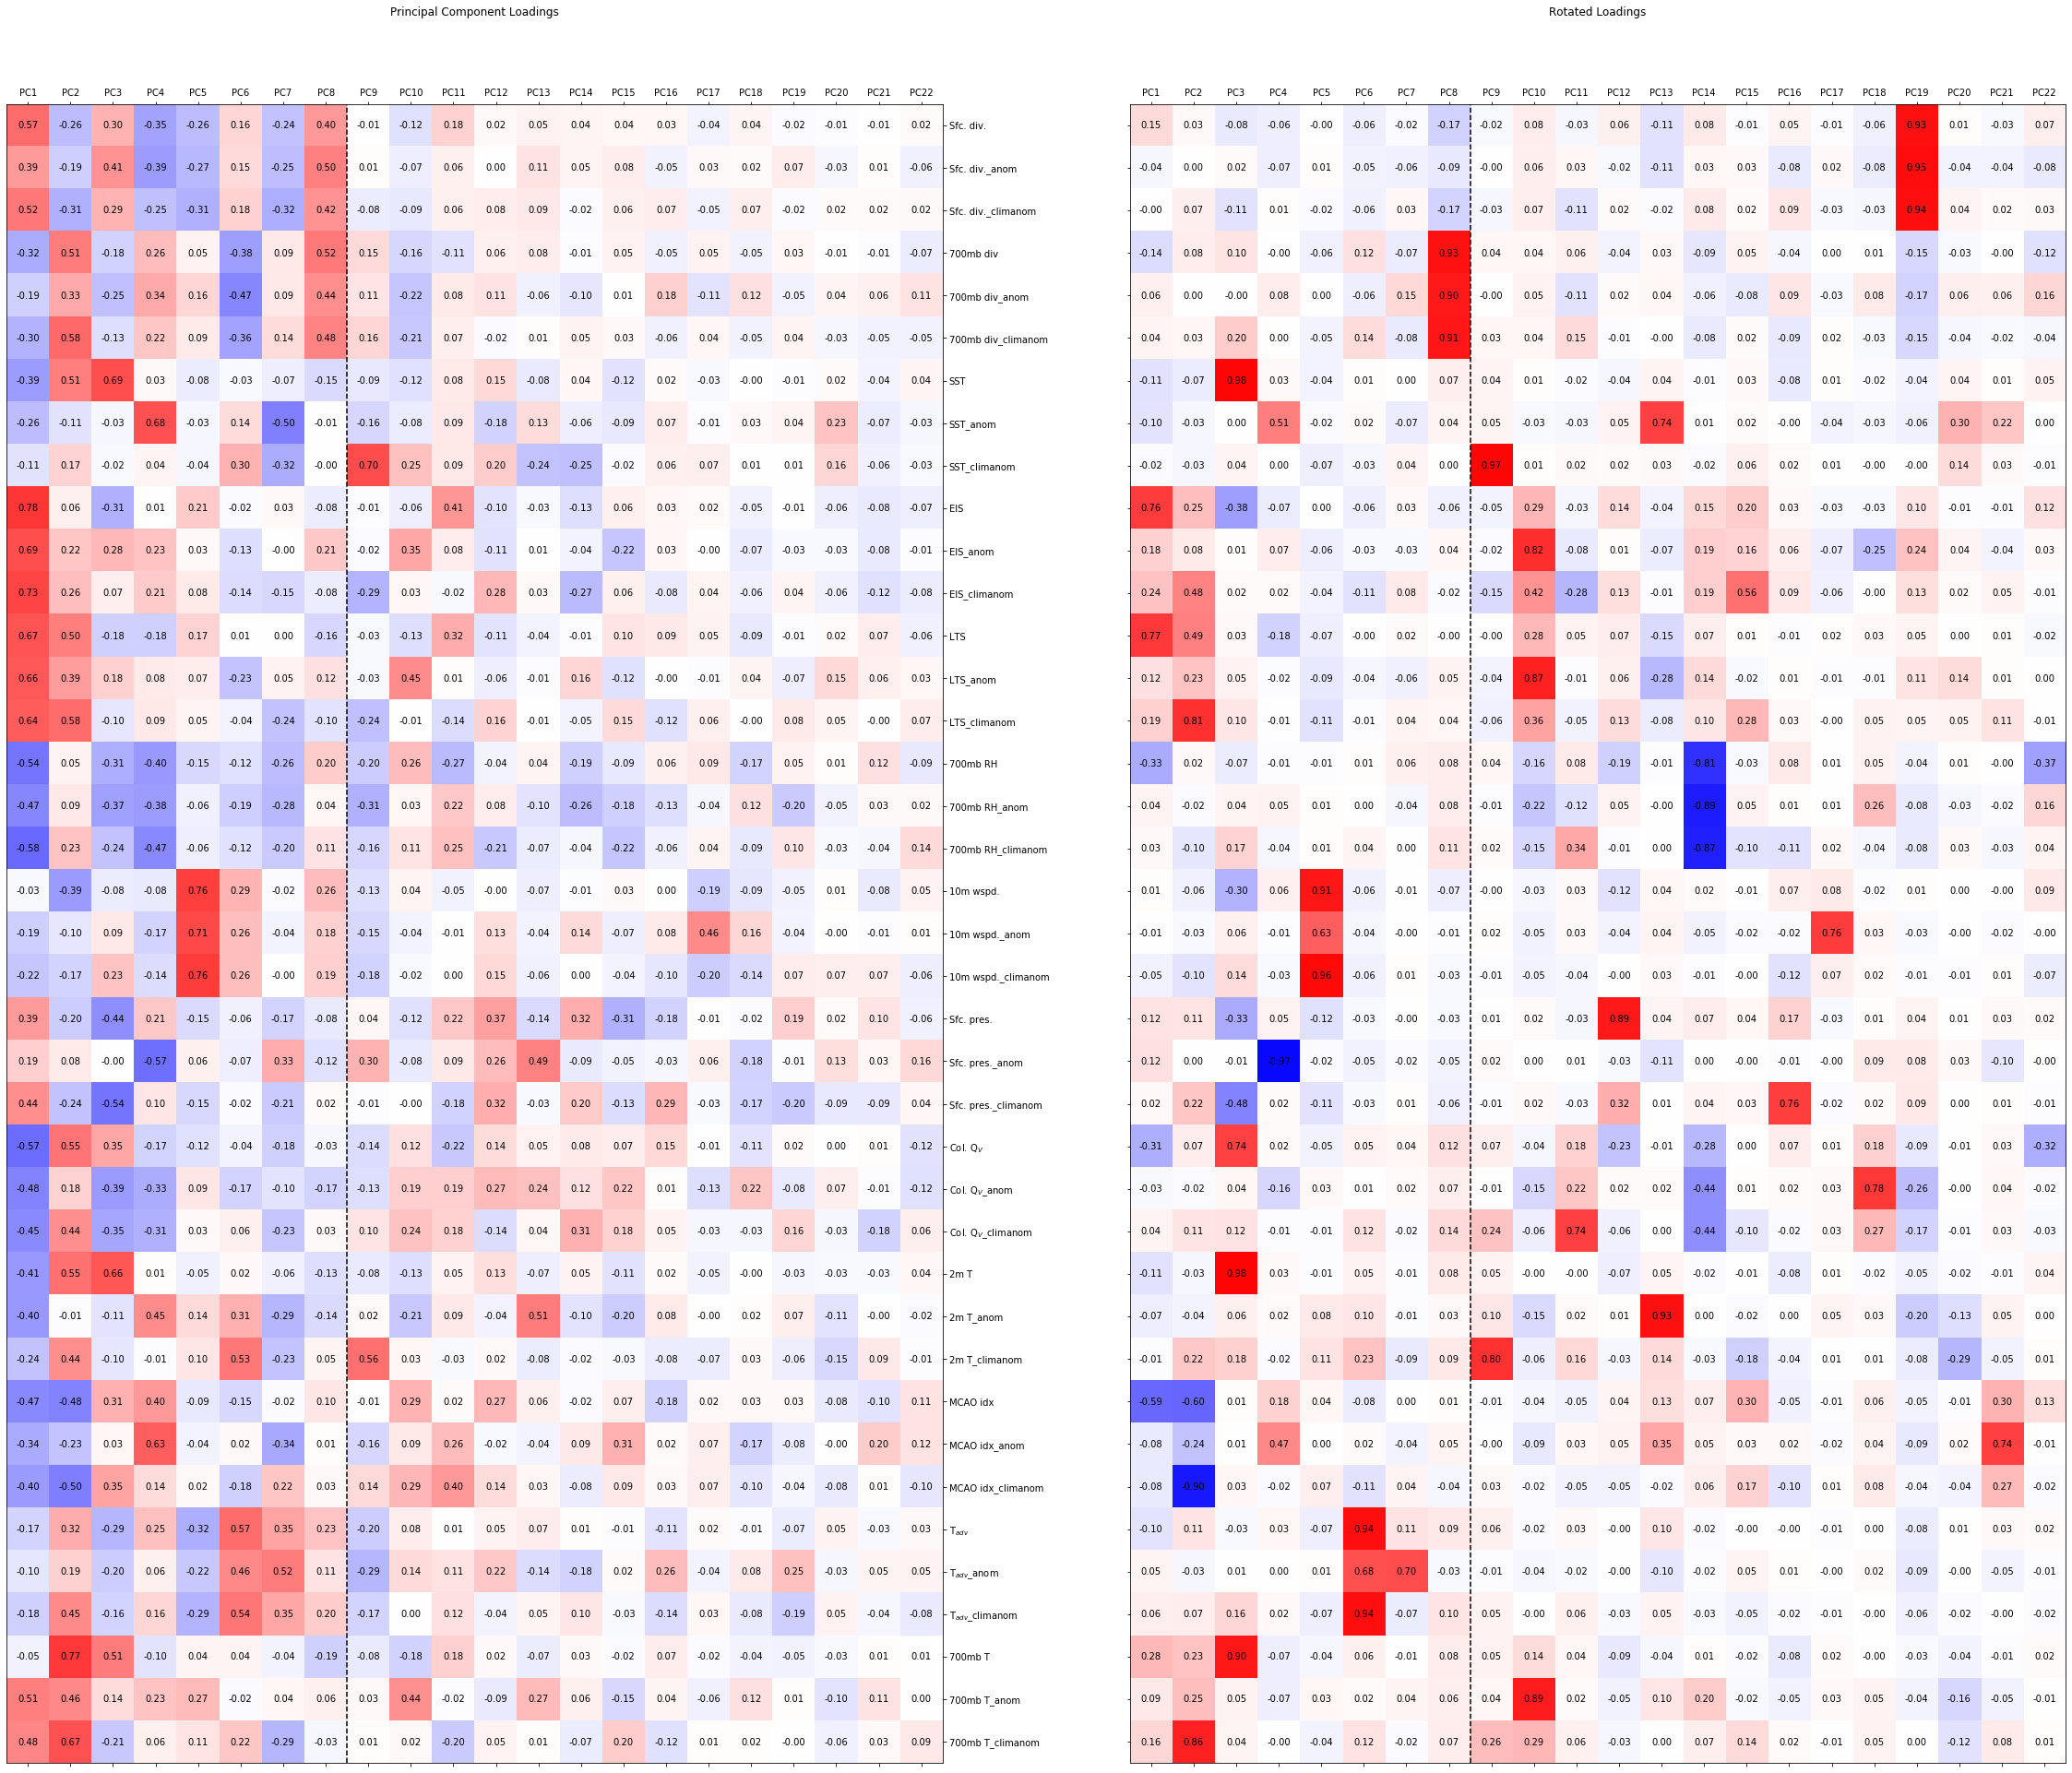

In [143]:
# Plotting Loadings from PC
fig, (ax1, ax2) = plt.subplots(figsize=(40,40), ncols=2, sharey=True)
show_loadings(loadings.T, var_labels, ax=ax1, vmin=-1, vmax=1)
show_loadings(rot_loadings.T, var_labels, ax=ax2, vmin=-1, vmax=1)
ax1.set_title('Principal Component Loadings')
ax1.axvline(7.5, c='k', ls='--')
ax2.axvline(7.5, c='k', ls='--')
ax2.set_title('Rotated Loadings')
ax1.yaxis.tick_right()
fig.subplots_adjust(wspace=0.20)
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/ch3_loadings.png', bbox_inches='tight')

In [144]:
# data_dict = dict(
#     x_train = rot_norm_pcs,
#     y_train = train_cats,
#     y_train_cf = train_labels,
#     x_val = rot_norm_pcs_val,
#     y_val = val_cats,
#     y_val_cf = val_labels,
#     x_all = rot_norm_pcs_all,
#     y_all = strat_data,
#     y_all_cf = y_data,
#     loadings = rot_loadings,
#     scaler = x_scaler,
#     var_names = vars_to_use)

# with open('/home/disk/eos4/jkcm/Data/MEASURES/classified_data/PCA_data.pickle' ,'wb') as f:
#     pickle.dump(data_dict, f)

# Part 2: Model Training, tuning, and basic evaluation

Just to set expectactions, what would a totally crap ML model do? Well, for balanced binary classification, it would just flip a coin, so it would be right half the time. What about for unbalanced binary classification? Let's say the dataset was 25% blue, 75% red? Well the model could be 75% right if it just guessed 'red' all the time, but let's say it's trying its best with no information. In that case it would guess blue 25% and red 75%, and so be correct (.25*.25 + .75*.75=)62.5% of the time. Actually worse than 'just guess the most often', but a more honest baseline. This would also do a better job minimizing variance in per-category scores. So let's use this as our baseline for our model, where the 'worse-case' performance is either 1) frequency of most common type (in our case 32% for supp), but then it's 100% wrong on the other cats, or each cat's score is it's freq, and the overall score in the sum of squared frequencies. Alternatively, if weighted 

In [145]:
def eval_model(model, x_eval, y_eval, labels=labels, ordering=ordering):
    for i in ordering:
        arr = y_eval==i
        x_eval_i = x_eval[arr]
        y_eval_i = y_eval[arr]
        sc = model.score(x_eval_i, y_eval_i)
        freq_of_type = np.sum(arr)/len(arr)
        print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

    sc = model.score(x_eval, y_eval)
    print(f'\nOverall score:      {sc:0.0%}')
    
def test_model(model):
    eval_model(model, x_eval=rot_norm_pcs_test, y_eval=test_cats)
    
def validate_model(model):
    eval_model(model, x_eval=rot_norm_pcs_val, y_eval=val_cats)

In [146]:
# baseline score
tot = 0
for i in np.unique(val_cats):
    arr = val_cats==i
    freq_of_type = np.sum(arr)/len(arr)
    print(f'baseline score for {labels[i]}: {freq_of_type:0.0%}')
    tot += freq_of_type**2
print(f'\n baseline Overall score: {tot:0.0%}')


baseline score for Closed-cellular MCC: 12%
baseline score for Clustered cumulus: 31%
baseline score for Disorganized MCC: 18%
baseline score for Open-cellular MCC: 3%
baseline score for Solid Stratus: 11%
baseline score for Suppressed Cu: 24%

 baseline Overall score: 22%


In [149]:
rf_params = dict(
    n_estimators = 100, 
    random_state = 41, 
    n_jobs=12, 
    max_features=k//2,
    min_samples_leaf=2,
    class_weight='balanced_subsample')

rf = RandomForestClassifier(**rf_params)
rf.fit(rot_norm_pcs, train_cats)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features=11, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=12, oob_score=False,
                       random_state=41, verbose=0, warm_start=False)

In [150]:
sc = rf.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}\n')
print('validation results:')
print(classification_report(val_cats,  rf.predict(rot_norm_pcs_val), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))
print('test results:')
print(classification_report(test_cats, rf.predict(rot_norm_pcs_test), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))


Training score:      100%

validation results:
                     precision    recall  f1-score   support

      Solid Stratus       0.61      0.56      0.58      8379
Closed-cellular MCC       0.60      0.67      0.63      9669
   Disorganized MCC       0.54      0.57      0.56     14461
  Open-cellular MCC       0.55      0.27      0.36      2565
  Clustered cumulus       0.59      0.65      0.62     24556
      Suppressed Cu       0.64      0.55      0.59     18937

           accuracy                           0.59     78567
          macro avg       0.59      0.55      0.56     78567
       weighted avg       0.59      0.59      0.59     78567

test results:
                     precision    recall  f1-score   support

      Solid Stratus       0.54      0.48      0.51     21953
Closed-cellular MCC       0.49      0.57      0.52     24864
   Disorganized MCC       0.40      0.47      0.43     33532
  Open-cellular MCC       0.37      0.13      0.19      7155
  Clustered cumulus

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


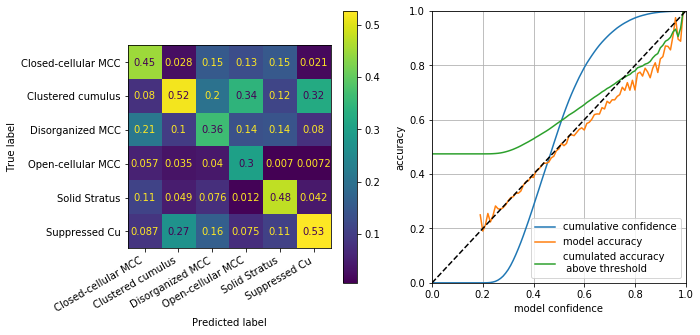

In [64]:
#model calibration
probs = rf.predict_proba(rot_norm_pcs_test)
max_probs = np.max(probs, axis=1)
true = test_cats
preds = rf.predict(rot_norm_pcs_test)
confs = np.arange(0,1,0.01)
cum_confs = np.zeros_like(confs)
mean_scores = np.zeros_like(confs)
gt_scores = np.zeros_like(confs)
for i,c in enumerate(confs):
    where_conf = np.logical_and(max_probs>c, max_probs<(c+np.diff(confs)[2]))
    where_gt_conf = max_probs>c
    mean_scores[i] =np.sum(preds[where_conf]==true[where_conf])/np.sum(where_conf)
    gt_scores[i] = np.sum(preds[where_gt_conf]==true[where_gt_conf])/np.sum(where_gt_conf)
    cum_confs[i] = np.sum(max_probs<c)/len(max_probs)

fig, [ax1, ax2] = plt.subplots(figsize=(10, 5), ncols=2)
plot_confusion_matrix(rf, rot_norm_pcs_test, y_true=test_cats, display_labels=[labels[i] for i in rf.classes_],
                     normalize='pred', xticks_rotation=30, ax=ax1)
ax1.set_xticklabels([i.get_text() for i in ax1.get_xticklabels()], ha='right')
ax2.plot(confs, cum_confs, label='cumulative confidence')
ax2.plot(confs, mean_scores, label='model accuracy')
ax2.plot(confs, gt_scores, label='cumulated accuracy \n above threshold')
ax2.plot((0,1),(0,1),'--k')
ax2.set_xlabel('model confidence')
ax2.set_ylabel('accuracy')
ax2.set_xlim((0,1))
ax2.set_ylim((0,1))
ax2.grid(True)
ax2.legend()
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/model_performance.png', bbox_inches='tight')

In [61]:
# this is a second model, trained with the regular unscaled, un-PCA'd training data
rf_npc = RandomForestClassifier(**rf_params)
# Train the model on training data
rf_npc.fit(train_features, train_cats)
#model accuracy per category
print("NON-PCA model test results:")
for i in np.unique(test_cats):
    arr = test_cats==i
    test_features_i = test_data[arr]
    test_cats_i = test_cats[arr]
    sc = rf_npc.score(test_features_i, test_cats_i)
    print(f'score for {labels[i]}:      {sc:0.0%}')
    
sc = rf_npc.score(test_data, test_cats)
print(f'\nOverall score:      {sc:0.0%}')

NON-PCA model test results:
score for Closed-cellular MCC:      52%
score for Clustered cumulus:      58%
score for Disorganized MCC:      46%
score for Open-cellular MCC:      14%
score for Solid Stratus:      49%
score for Suppressed Cu:      49%

Overall score:      50%


In [78]:
train_subset.columns

Index(['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS',
       'MERRA2_LTS', 'MERRA2_RH_700', 'MERRA2_WSPD_10M', 'MERRA2_PS',
       'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700',
       'low_cf', 'cat', 'lat', 'lon'],
      dtype='object')

In [71]:
(train_subset+test_subset).shape

(502384, 17)

In [90]:
dt.utcnow()

NameError: name 'dt' is not defined

In [97]:
pd.concat([train_subset,test_subset],ignore_index=True)

(502384, 17)

In [98]:
# adding in classifications and saving
subset_df_all = pd.concat([train_subset,test_subset],ignore_index=True)
probs_train = rf.predict_proba(rot_norm_pcs_all)
max_probs_train = np.max(probs_train, axis=1)
preds_train = rf.predict(rot_norm_pcs_all)
probs_test = rf.predict_proba(rot_norm_pcs_test)
max_probs_test = np.max(probs_test, axis=1)
preds_test = rf.predict(rot_norm_pcs_test)
max_probs_all = np.hstack([max_probs_train, max_probs_test])
preds_all = np.hstack([preds_train, preds_test])
subset_df_all['rf_prob'] = max_probs_all
subset_df_all['rf_pred'] = preds_all
pickle.dump(subset_df_all, open(f'/home/disk/eos4/jkcm/Data/MEASURES/models/rf_ver1_classified_data.pickle', "wb" ))



# Part 3: Feature importance, Partial Dependencies

In [51]:
# feat_import_npc = permutation_importance(rf_npc, test_data, test_cats, n_jobs=8)
feat_import = permutation_importance(rf, rot_norm_pcs_test, test_cats, n_repeats=10, n_jobs=8)

In [52]:
def feature_importance_by_category(model, test_features, test_cats):
    cat_dict = {}
    for i in np.unique(test_cats):
        arr = test_cats==i
        test_features_i = test_features[arr]
        test_cats_i = test_cats[arr]
        pfi = permutation_importance(model, test_features_i, test_cats_i, n_jobs=4)
        cat_dict[i] = pfi
    return cat_dict
# feat_import_npc_by_cat = feature_importance_by_category(rf_npc, test_features, test_cats)
feat_import_by_cat = feature_importance_by_category(rf, rot_norm_pcs_test, test_cats)


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feaa2e31e50>)

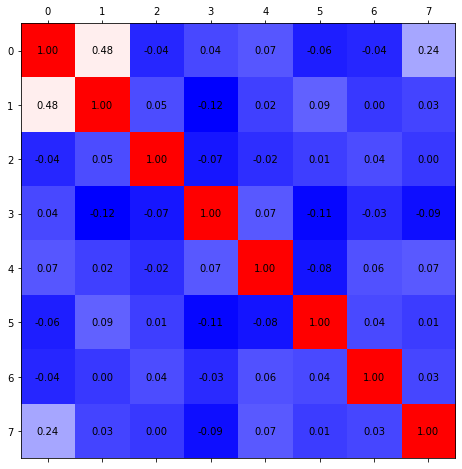

In [104]:
arr = np.isin(test_cats, [0,3])
x = np.corrcoef(rot_norm_pcs_test[arr].T)
show_matrix(x)

In [54]:
arr = np.isin(test_cats, [1, 5])
cu_feat_import = permutation_importance(rf,  rot_norm_pcs_test[arr], test_cats[arr], n_repeats=10, n_jobs=8)

In [55]:
arr = np.isin(test_cats, [0, 3])
mcc_feat_import = permutation_importance(rf,  rot_norm_pcs_test[arr], test_cats[arr], n_repeats=10, n_jobs=8)

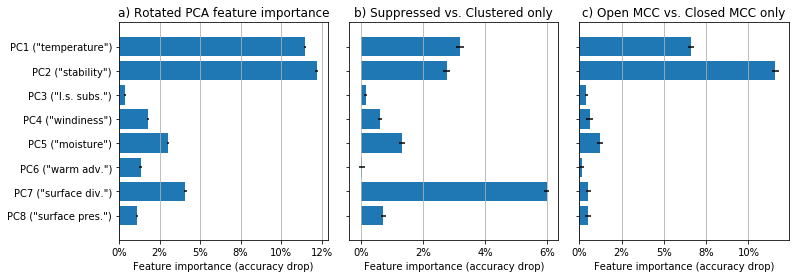

In [71]:
def plot_pfi(pfi, labs, title='', ax=None):
    if not ax:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    means = pfi['importances_mean']*100
    stds = pfi['importances_std']*100
    ax.barh(range(len(means)), means, xerr=stds, align='center')
    ax.set_yticks(np.arange(len(means)))
    ax.set_yticklabels(labs)
    ax.set_xlabel("Feature importance (accuracy drop)")
#     ax.set_label("Feature")
    ax.set_ylim(-1, len(means))
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set_xticklabels([f'{i:0.0f}%' for i in ax.get_xticks()])
    return fig, ax
cols = ['"temperature"', '"stability"', '"l.s. subs."', '"windiness"', '"moisture"', '"warm adv."', 
        '"surface div."', '"surface pres."']
# fig_npc, ax_npc = plot_pfi(feat_import_npc, vars_to_use, 'raw permutation feature importance (no PCA)')

fig, [ax1, ax2, ax3] = plt.subplots(figsize=(12,4), ncols=3, sharey=True)
plot_pfi(feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'a) Rotated PCA feature importance', ax=ax1)
plot_pfi(cu_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'b) Suppressed vs. Clustered only', ax=ax2)
plot_pfi(mcc_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'c) Open MCC vs. Closed MCC only', ax=ax3)
# ax1.yaxis.tick_right()
fig.subplots_adjust(wspace=0.1)
fig.savefig('/home/disk/p/jkcm/plots/dissertation/feature_importance.png', bbox_inches='tight')


# fig, ax = plot_pfi(mcc_feat_import, [f'PC{i+1} ({cols[i]})' for i in range(k)], 'MCC-only feature import')


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f255a5bc750>)

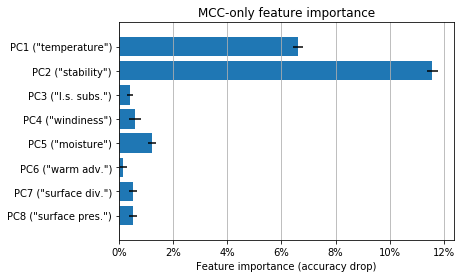

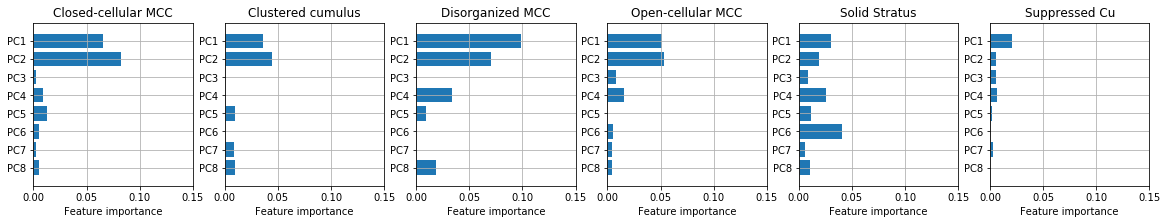

In [30]:
fig, ax = plt.subplots(ncols=6, figsize=(20,3))
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_by_cat[key]['importances_mean'], [f'PC{i+1}' for i in range(k)], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.15))

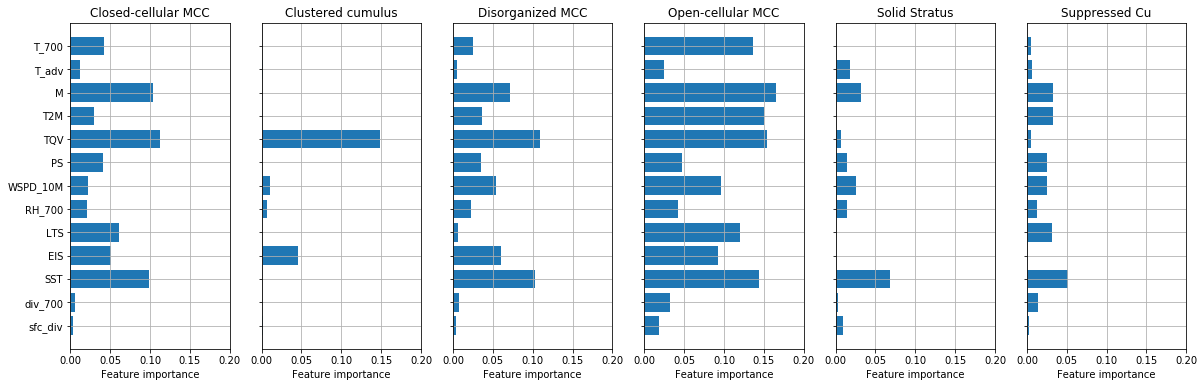

In [64]:
fig, ax = plt.subplots(ncols=6, figsize=(20,6), sharey=True)
for axi, key in zip(ax, list(feat_import_by_cat.keys())):
    plot_pfi(feat_import_npc_by_cat[key]['importances_mean'], [i[7:] for i in vars_to_use], labels[int(key)], ax=axi)
for axi in ax:
    axi.grid(True)
    axi.set_xlim((0, 0.2))

In [18]:
model_save_dict = dict(
    model=rf,
    x_test = rot_norm_pcs_test,
    x_train = rot_norm_pcs,
    loadings =rot_loadings,
    pct_var = pct_var,
    pct_var_rot = pct_var_rot)

pickle.dump(model_save_dict, open(f'/home/disk/eos4/jkcm/Data/MEASURES/models/simple_rf_pca_model.pickle', "wb" ))


In [19]:
# This is a very computationally intensive calculation, and should be batched out and done on a separate node, to avoid clogging the main fileserver

for target in rf.classes_:
    break
#     pdp = plot_partial_dependence(rf, rot_norm_pcs_test, features=[0, 1, 2, 3, 4, 5, 6, 7], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
#                             target=target, verbose=True, n_jobs=4)
    pdp_2d = plot_partial_dependence(rf, rot_norm_pcs_test, features=[(0,1), (0,4), (2,6)], feature_names=[f'PC{i+1}' for i in range(loadings.shape[0])], 
                            target=target, verbose=True, n_jobs=4)
    pickle.dump(pdp, open(f'/home/disk/eos4/jkcm/Data/MEASURES/pdp/ver1_pdp_target_2d_{target}.pickle', "wb" ))

# for target in rf.classes_

# Part 4: What if we did a regression instead?

In [176]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(rot_norm_pcs,train_labels)
lm.score(rot_norm_pcs_test,test_labels)

# predictions = lm.predict(X)
# print(predictions)[0:5]

0.33391864429931506

In [172]:
rf_r_params = dict(
    n_estimators=50,
    criterion='mse',
    min_samples_leaf=2,
    max_features='auto',
    n_jobs=16,
    random_state=10,
    max_samples=0.5,
)

In [173]:
rf_r = RandomForestRegressor(**rf_r_params)
rf_r.fit(rot_norm_pcs, train_labels)
print("PCA regression on low CF:")
# for i in np.unique(val_cats):
#     arr = val_cats == i
#     val_features_i = rot_norm_pcs_val[arr]
#     val_labels_i = val_labels[arr]
#     sc = rf_r.score(val_features_i, val_labels_i)
#     freq_of_type = np.sum(arr)/len(arr)
#     print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.2}')
    
sc = rf_r.score(rot_norm_pcs_test, test_labels)
print(f'\nOverall score:      {sc:0.2}')

# sc = rf_r.score(rot_norm_pcs, train_labels)
# print(f'\nTraining score:      {sc:0.0%}')
# if True:
#     scores = cross_val_score(rf_r, x_all, y_data, cv=3)
#     scores

PCA regression on low CF:

Overall score:      0.44


In [174]:
sc = rf_r.score(rot_norm_pcs_test, test_labels)


In [175]:
sc

0.3583947281385004

In [78]:
cats = np.concatenate([rot_norm_pcs_all, y_data[:,None]], axis=1)


In [82]:
pd.to_dataframe(cats)

AttributeError: module 'pandas' has no attribute 'to_dataframe'

In [26]:
corr = train_subset[train_subset.lat>-50].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MERRA2_sfc_div,MERRA2_div_700,MERRA2_SST,MERRA2_EIS,MERRA2_LTS,MERRA2_RH_700,MERRA2_WSPD_10M,MERRA2_PS,MERRA2_TQV,MERRA2_T2M,MERRA2_M,MERRA2_T_adv,MERRA2_T_700,low_cf,cat,lat
MERRA2_sfc_div,1.00,-0.41,-0.15,0.31,0.22,-0.23,0.03,0.16,-0.30,-0.16,-0.18,-0.16,-0.03,-0.09,0.09,-0.11
MERRA2_div_700,-0.41,1.00,0.18,-0.22,-0.09,0.25,-0.15,-0.14,0.33,0.20,0.08,0.22,0.13,0.03,0.02,0.15
MERRA2_SST,-0.15,0.18,1.00,-0.44,-0.11,0.03,-0.24,-0.50,0.74,0.99,0.14,0.00,0.82,-0.40,0.17,0.87
MERRA2_EIS,0.31,-0.22,-0.44,1.00,0.84,-0.53,0.06,0.42,-0.65,-0.46,-0.55,-0.17,0.04,0.32,-0.20,-0.40
MERRA2_LTS,0.22,-0.09,-0.11,0.84,1.00,-0.37,-0.11,0.19,-0.25,-0.10,-0.79,-0.09,0.45,0.30,-0.14,-0.05
MERRA2_RH_700,-0.23,0.25,0.03,-0.53,-0.37,1.00,-0.07,-0.24,0.56,0.05,0.08,0.10,-0.14,0.09,0.04,0.13
MERRA2_WSPD_10M,0.03,-0.15,-0.24,0.06,-0.11,-0.07,1.00,-0.08,-0.24,-0.21,0.06,-0.13,-0.24,0.21,-0.11,-0.19
MERRA2_PS,0.16,-0.14,-0.50,0.42,0.19,-0.24,-0.08,1.00,-0.55,-0.54,-0.05,-0.04,-0.43,0.18,-0.12,-0.64
MERRA2_TQV,-0.30,0.33,0.74,-0.65,-0.25,0.56,-0.24,-0.55,1.00,0.76,0.11,0.12,0.56,-0.19,0.13,0.75
MERRA2_T2M,-0.16,0.20,0.99,-0.46,-0.10,0.05,-0.21,-0.54,0.76,1.00,0.09,0.05,0.83,-0.40,0.18,0.88


# A very simple model

In [20]:
vars_to_use = ['MERRA2_sfc_div', 'MERRA2_div_700', 'MERRA2_SST', 'MERRA2_EIS', 'MERRA2_LTS', 'MERRA2_RH_700', 
               'MERRA2_WSPD_10M', 'MERRA2_PS', 'MERRA2_TQV', 'MERRA2_T2M', 'MERRA2_M', 'MERRA2_T_adv', 'MERRA2_T_700']  # these are the variables to train on
train_subset = all_sep_df[vars_to_use + ['low_cf', 'cat', 'lat']].copy()  # including two different y variables.
train_subset.loc[np.abs(train_subset['MERRA2_T_adv'].values*86400)>5, 'MERRA2_T_adv'] = np.nan
train_subset = train_subset.dropna(axis='index')

labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}

subset_categories = [0,3]
if subset_categories:
    train_subset = train_subset[[i in subset_categories for i in train_subset['cat']]]
    labels = {k: v for k, v in labels.items() if k in subset_categories}
    
train_subset = train_subset[train_subset.lat>-30]
    
    
subset_vars = vars_to_use; ['MERRA2_EIS', 'MERRA2_T_700']
subset_labels = var_labels;['EIS', 'T$_{700}$']
    # Split the data into training and validation sets - since we have a separate test set, we can look at these all we want.
x_data = train_subset[subset_vars].values.copy()
y_data = train_subset['low_cf'].values.copy()
strat_data = train_subset['cat'].values.copy()  # this is the stratification variable - lets make sure we have the right amount of each category in both datasets.
simple_train_features, simple_test_features, simple_train_labels, simple_test_labels, simple_train_cats, simple_test_cats = train_test_split(
    x_data, y_data, strat_data, test_size = 0.25, random_state = 42, stratify=strat_data)

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [21]:
# model for the PC-transformed data
dtc = DecisionTreeClassifier(max_depth=3, splitter='best', class_weight='balanced')
# Train the model on training data
dtc.fit(simple_train_features, simple_train_cats)
#model accuracy per category
print("decision tree model:")
for i in np.unique(simple_test_cats):
    arr = simple_test_cats==i
    test_features_i = simple_test_features[arr]
    test_cats_i = simple_test_cats[arr]
    sc = dtc.score(test_features_i, test_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = dtc.score(simple_test_features, simple_test_cats)
print(f'\nOverall score:      {sc:0.0%}')

if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

decision tree model:
score for Closed-cellular MCC (78%):      71%
score for Open-cellular MCC (22%):      75%

Overall score:      72%


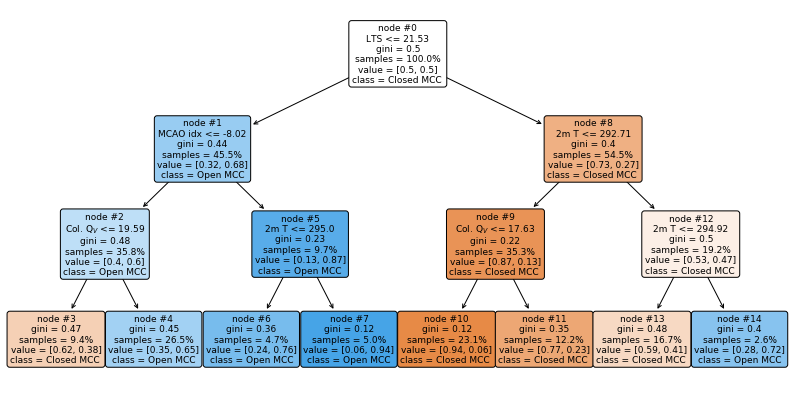

In [40]:
fig, ax = plt.subplots(figsize=(14,7))

plot_tree(dtc,
          feature_names = subset_labels, 
          class_names=[short_labels[i] for i in dtc.classes_],
          rounded=True,
          proportion=True,
          precision=2,
          node_ids=True,
          filled = True, ax=ax);
fig.savefig('/home/disk/p/jkcm/plots/dissertation/sample_decision_tree.png', bbox_inches='tight')

# Aside: CCA

In [128]:
from sklearn.cross_decomposition import CCA
X = x_all
Y = y_data
cca = CCA(n_components=1)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

In [122]:
X_c2 = np.matmul(X, cca.x_weights_)

In [132]:
cca.score(X,)

-6.840172012288013

In [133]:
cca.score(x_test, test_labels)

0.2209189546587309

In [135]:
x_test_c = np.matmul(x_test, cca.x_weights_)

In [139]:
np.corrcoef(x_test_c[:,0], test_labels)[0][1]**2

0.38104740963221295

In [125]:
X_c-X_c2

array([[1.87515729e-04],
       [9.53179080e-05],
       [1.30895018e-05],
       ...,
       [2.82193393e-04],
       [2.55335806e-04],
       [2.41674246e-04]])

In [116]:
X.shape

(305089, 13)

0.2209189546587309

In [118]:
X_c.shape

(305089, 1)

In [94]:
cca.x_loadings_

array([[ 0.49532554],
       [-0.12392827],
       [ 3.02110283],
       [-2.39069012],
       [-2.01268852],
       [-0.79673379],
       [-1.58505837],
       [-1.16169785],
       [ 1.56887333],
       [ 3.00677202],
       [ 2.0395103 ],
       [ 0.75538559],
       [ 1.71320467]])

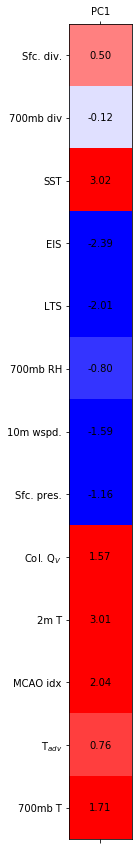

In [97]:
# Plotting Loadings from CCA
fig, ax = plt.subplots(figsize=(7,15), ncols=1)
show_loadings(cca.x_loadings_.T, var_labels, ax=ax, vmin=-1, vmax=1)
# show_loadings(rot_loadings.T, var_labels, ax=ax2, vmin=-1, vmax=1)
# ax1.set_title('Principal Component Loadings')
# ax1.axvline(7.5, c='k', ls='--')
# ax2.axvline(7.5, c='k', ls='--')
# ax2.set_title('Rotated Loadings')
# ax1.yaxis.tick_right()
# fig.subplots_adjust(wspace=0.20)
# fig.savefig('/home/disk/p/jkcm/plots/dissertation/ch3_loadings.png', bbox_inches='tight')

In [113]:
np.corrcoef(X_c[:,0], Y_c)[0][1]**2

0.40701346790825227

In [109]:
test_c = 

(305089,)

In [178]:
# Support Vector Machines? Again? Really trying hard for that nostalgia anxiety huh. Nope, fit time too high
# KNN it is!
from sklearn.neighbors import KNeighborsClassifier

In [180]:
knn_params = dict(
    algorithm='kd_tree',
    n_neighbors=10, n_jobs=16)

In [149]:
knn = KNeighborsClassifier(**knn_params)
knn.fit(rot_norm_pcs, train_cats)

print("PCA KNN model:")
for i in np.unique(val_cats):
    arr = val_cats==i
    val_features_i = rot_norm_pcs_val[arr]
    val_cats_i = val_cats[arr]
    sc = knn.score(val_features_i, val_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')
    
sc = knn.score(rot_norm_pcs_val, val_cats)
print(f'\nOverall score:      {sc:0.0%}')

sc = knn.score(rot_norm_pcs, train_cats)
print(f'\nTraining score:      {sc:0.0%}')
if False:
    scores = cross_val_score(rf, x_all, strat_data, cv=5)

PCA KNN model:
score for Closed-cellular MCC (12%):      56%
score for Clustered cumulus (32%):      62%
score for Disorganized MCC (19%):      44%
score for Open-cellular MCC (3%):      11%
score for Solid Stratus (10%):      39%
score for Suppressed Cu (24%):      45%

Overall score:      50%

Training score:      59%


In [182]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [184]:
hgb = HistGradientBoostingClassifier(max_iter=100).fit(rot_norm_pcs, train_cats)
hgb.score(rot_norm_pcs_val, val_cats)

0.5169325973804623

In [185]:
hgb.score(rot_norm_pcs_test, test_cats)

0.4911427050862921

In [186]:

print("PCA HistGBC model:")
for i in np.unique(test_cats):
    arr = test_cats==i
    test_features_i = rot_norm_pcs_test[arr]
    test_cats_i = test_cats[arr]
    sc = hgb.score(test_features_i, test_cats_i)
    freq_of_type = np.sum(arr)/len(arr)
    print(f'score for {labels[i]} ({freq_of_type:0.0%}):      {sc:0.0%}')

sc = hgb.score(rot_norm_pcs_test, test_cats)
print(f'\nOverall score:      {sc:0.0%}')

# sc = hgb.score(rot_norm_pcs, train_cats)
# print(f'\nTraining score:      {sc:0.0%}')

PCA HistGBC model:
score for Closed-cellular MCC (12%):      47%
score for Clustered cumulus (32%):      62%
score for Disorganized MCC (17%):      44%
score for Open-cellular MCC (3%):      7%
score for Solid Stratus (10%):      41%
score for Suppressed Cu (26%):      45%

Overall score:      49%


In [ ]:
# Extra Random Tree model for the PC-transformed data
rf_extra = ExtraTreesClassifier(**rf_params)
# Train the model on training data
rf_extra.fit(rot_norm_pcs, train_cats)
print("ExtraTrees PCA model validation:")
test_model(rf_extra)

sc = rf_extra.score(rot_norm_pcs_test, test_cats)
print(f'\nTraining score:      {sc:0.0%}')

In [169]:
# what if we just used a classifier to predict cloud fraction???
rf_params = dict(
    n_estimators = 100, 
    random_state = 43, 
    n_jobs=12, 
    max_features='auto',
    min_samples_leaf=2,
    class_weight='balanced_subsample')

rf = RandomForestClassifier(**rf_params)
rf.fit(rot_norm_pcs, train_cats_cf)
sc = rf.score(rot_norm_pcs, train_cats_cf)
print(f'\nTraining score:      {sc:0.0%}\n')
print('validation results:')
print(classification_report(val_cats_cf,  rf.predict(rot_norm_pcs_val), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))
print('test results:')
# print(classification_report(test_cats_cf, rf.predict(rot_norm_pcs_test), digits=2, labels=ordering, target_names=[labels[i] for i in ordering]))


Training score:      100%

validation results:
                     precision    recall  f1-score   support

      Solid Stratus       0.31      0.27      0.29     12689
Closed-cellular MCC       0.41      0.52      0.46     12829
   Disorganized MCC       0.27      0.21      0.24     12782
  Open-cellular MCC       0.29      0.23      0.25     12757
  Clustered cumulus       0.30      0.28      0.29     12476
      Suppressed Cu       0.52      0.69      0.59     12740

           accuracy                           0.37     76273
          macro avg       0.35      0.37      0.35     76273
       weighted avg       0.35      0.37      0.35     76273

test results:


In [181]:
knn = KNeighborsClassifier(**knn_params)
knn.fit(rot_norm_pcs, train_cats_cf)


sc = knn.score(rot_norm_pcs_val, val_cats_cf)
print(f'\nOverall score:      {sc:0.0%}')

sc = knn.score(rot_norm_pcs_test, test_cats_cf)
print(f'\nTraining score:      {sc:0.0%}')


Overall score:      34%

Training score:      30%


In [131]:
print(rot_norm_pcs_all.shape)
train_subset.shape
preds = rf.predict(rot_norm_pcs_all)
train_subset['preds'] = preds

test_preds = rf.predict(rot_norm_pcs_test)
test_subset['preds'] = test_preds

(305089, 8)


In [132]:
plot_df = test_subset
from matplotlib import colors
import utils


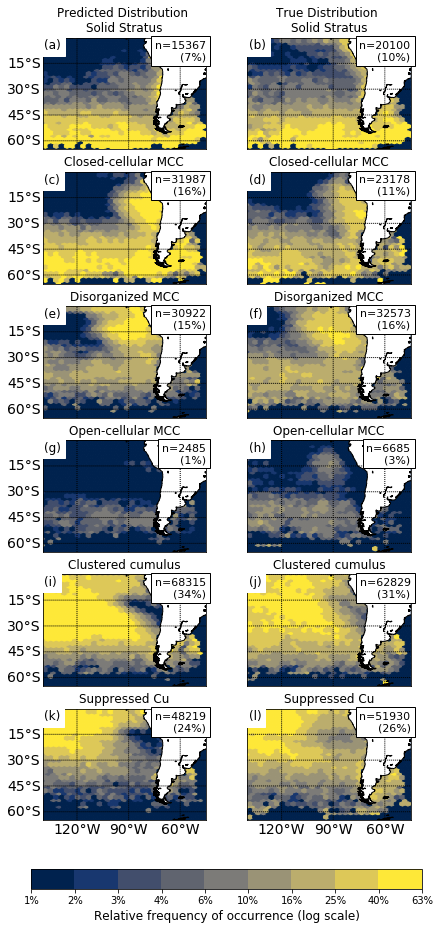

In [152]:
llr = {'lat':(-65,0), 'lon':(220,315)}
ticks = np.logspace(-2, 0, 11)[:-1]
bnorm = colors.BoundaryNorm(boundaries=ticks, ncolors=256)
lnorm = colors.LogNorm(vmin=0.01, vmax=0.7)

fig, ax = plt.subplots()
b = utils.bmap(ax=ax, llr=llr)
image = b.hexbin(plot_df['lon'], plot_df['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']))
all_counts = image.get_array()+1
plt.close()



fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(7,18), sharex=True, sharey=True)
axn = ax[:,0].flatten()
for cat, name  in utils.labels.items():
    axi = axn[utils.ordering.index(cat)]
    df_sub = plot_df[plot_df['preds']==cat]
    par_labs = [1, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if cat in [5] else [0, 0, 0, 0]
    b = utils.bmap(ax=axi, llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)

    image = b.hexbin(df_sub['lon'], df_sub['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']), norm=bnorm, cmap='cividis')
    normed_counts = image.get_array()/all_counts
    normed_counts[all_counts==1] = np.nan
    image.set_array(normed_counts)
    nstr = f"n={sum(df_sub['preds']==cat)}\n({int(sum(df_sub['preds']==cat)*100/len(plot_df))}%)"
    axi.set_title(name)
    axi.annotate(nstr, xy=(1, 0.8), xycoords='axes fraction', fontsize=11, c='k', ha='right', bbox={'facecolor': 'w', 'edgecolor': 'k'})
# cb = plt.colorbar(image, ax=axn, ticks=ticks, orientation='horizontal', pad=0.1)
# cb.set_ticklabels([f"{i:0.0%}" for i in ticks])
# cb.set_label("Relative frequency of occurrence (log scale)", fontsize=12)
ax[0,0].set_title('Predicted Distribution \n' +ax[0,0].get_title());



axn = ax[:,1].flatten()
for cat, name  in utils.labels.items():
    axi = axn[utils.ordering.index(cat)]
    df_sub = plot_df[plot_df['cat']==cat]
    par_labs = [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if cat in [5] else [0, 0, 0, 0]
    b = utils.bmap(ax=axi, llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)

    image = b.hexbin(df_sub['lon'], df_sub['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']), norm=bnorm, cmap='cividis')
    normed_counts = image.get_array()/all_counts
    normed_counts[all_counts==1] = np.nan
    image.set_array(normed_counts)
    nstr = f"n={sum(df_sub['cat']==cat)}\n({int(sum(df_sub['cat']==cat)*100/len(plot_df))}%)"
    axi.set_title(name)
    axi.annotate(nstr, xy=(1, 0.8), xycoords='axes fraction', fontsize=11, c='k', ha='right', bbox={'facecolor': 'w', 'edgecolor': 'k'})

# add_labels(axn)    
for i, axi in enumerate(ax.flatten()):
    axi.text(0.01, 0.99, f"({chr(ord('a') + i)})", fontsize=12, backgroundcolor='w',
             horizontalalignment='left', verticalalignment='top', transform=axi.transAxes)

plt.subplots_adjust(hspace=0.2, wspace=0.1)

cb = plt.colorbar(image, ax=ax, ticks=ticks, orientation='horizontal', pad=0.05)
cb.set_ticklabels([f"{i:0.0%}" for i in ticks])
cb.set_label("Relative frequency of occurrence (log scale)", fontsize=12)
ax[0,1].set_title('True Distribution \n' +ax[0,1].get_title());
fig.savefig('/home/disk/p/jkcm/plots/dissertation/map_comparison.png', bbox_inches='tight')


# fig.savefig('/home/disk/p/jkcm/plots/measures/final/SEP_classifications_map.png', bbox_inches='tight')

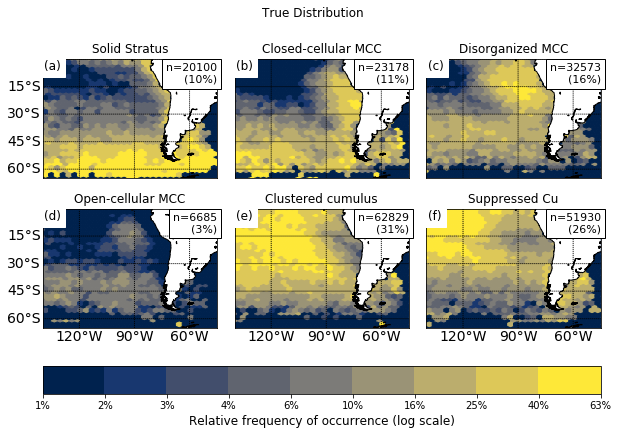

In [143]:
ax[1,1].get_title()

'Closed-cellular MCC'